# U-net for parcellation

- trained on cortical parcellations from Freesurfer
- (TO DO) finetuned on small dataset of "expert" hand-labels
- predicts output class for each pixel of input image

In [33]:
# I also like to live dangerously
import warnings
warnings.filterwarnings('ignore')

In [34]:
import user

In [35]:
from user.utils import y_vis_sample, from_onehot

In [4]:
import visual_autolabel as va
import user
from user.data import ToFloat

import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

# these are required for defining the regession ImageFolder
from typing import Dict, Any
from torchvision import datasets
from torchsummary import summary

In [5]:
import nilearn as ni
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import os
import numpy as np
import pandas as pd

from PIL import Image
from PIL import ImageOps
from PIL import ImagePalette

## 1. Set up directories and process data

In [6]:
in_channels = 1
out_channels = 21

In [56]:
def make_mapping_file(xdir, ydir, ldir, mapping_fname):
    if mapping_fname is None:
        mapping_fname = 'mapping_file.csv'
    
    x_fnames = os.listdir(xdir)
    y_fnames = os.listdir(ydir)
    x_id = [''.join(f.split('curv'))[:-4] for f in x_fnames]
    y_id = [''.join(f.split('parc'))[:-4]for f in y_fnames]

    x_df = pd.DataFrame({'Xname': x_fnames, 'ID': x_id})
    y_df = pd.DataFrame({'Yname': y_fnames, 'ID': y_id})

    mapping_df = pd.merge(x_df, y_df, how='inner', on='ID')
    mapping_df = mapping_df[['Xname', 'Yname', 'ID']]
    mapping_df.to_csv(f'{ldir}/{mapping_fname}', index=False, mode='w+')

In [50]:
base_dir = '/scratch/groups/jyeatman/samjohns-projects/data/parc-images-jitter-processed'
xdir = base_dir + '/curv-trans'
ydir = base_dir + '/parc-trans'
ldir = base_dir
mapping_fname = 'mapping_file_jitter_trans.csv'

## Create test-train split respecting subject EIDs

In [51]:
xdir_train = xdir + '-trn'
ydir_train = ydir + '-trn'
xdir_val = xdir + '-val'
ydir_val = ydir + '-val'

xs = os.listdir(xdir)
ys = os.listdir(ydir)

xeids = [s[:16] for s in xs]
yeids = [s[:16] for s in ys]

os.makedirs(xdir_train, exist_ok=True)
os.makedirs(ydir_train, exist_ok=True)
os.makedirs(xdir_val, exist_ok=True)
os.makedirs(ydir_val, exist_ok=True)

In [11]:
len(set(xeids) & set(yeids)), len(set(xeids)), len(set(yeids))

(2361, 2361, 2361)

In [12]:
xeids_unique = list(set(xeids))
yeids_unique = list(set(yeids))

In [29]:
val_size = len(xeids_unique) // 10
trn_size = len(xeids_unique) - val_size

In [34]:
val_eids = list(np.random.choice(xeids_unique, replace=False, size=val_size))

In [24]:
val_eids = list(np.load('val_eids.npy'))

In [25]:
trn_eids = list(set(xeids_unique) - set(val_eids))

In [26]:
len(trn_eids), len(val_eids)

(2125, 236)

In [27]:
set(trn_eids) & set(val_eids)

set()

In [37]:
copy_files = False
if copy_files:
    import shutil
    for y in ys:
        val = y[:16] in val_eids
        dst = ydir_val if val else ydir_train
        if val:
            shutil.copy(f'{ydir}/{y}', dst)
        else:
            shutil.copy(f'{ydir}/{y}', dst)

In [57]:
# make mapping files for train and val sets

mapping_file_exists = False
mapping_fname_trn = 'mapping-jitter-trans-trn.csv'
mapping_fname_val = 'mapping-jitter-trans-val.csv'
if not mapping_file_exists:
    make_mapping_file(xdir_train, ydir_train, ldir, mapping_fname_trn)
    make_mapping_file(xdir_val, ydir_val, ldir, mapping_fname_val)

In [62]:
trn_df = pd.read_csv(f'{ldir}/{mapping_fname_trn}')
val_df = pd.read_csv(f'{ldir}/{mapping_fname_val}')

In [63]:
# test
trn_df.head()

,Xname,Yname,ID
0,sub-NDARFN790WHU-210.62-81.89-curv-trans--12--...,sub-NDARFN790WHU-210.62-81.89-parc-trans--12--...,sub-NDARFN790WHU-210.62-81.89--trans--12--20
1,sub-NDARGB015CT3-208.56-82.77-curv-trans--22-1...,sub-NDARGB015CT3-208.56-82.77-parc-trans--22-1...,sub-NDARGB015CT3-208.56-82.77--trans--22-12
2,sub-NDARKM718VKX-201.47-92.39-curv-trans-0-0.npy,sub-NDARKM718VKX-201.47-92.39-parc-trans-0-0.npy,sub-NDARKM718VKX-201.47-92.39--trans-0-0
3,sub-NDARWE818UA6-219.09-76.41-curv-trans--16-8...,sub-NDARWE818UA6-219.09-76.41-parc-trans--16-8...,sub-NDARWE818UA6-219.09-76.41--trans--16-8
4,sub-NDARMA598JTX-212.60-95.18-curv-trans-0-0.npy,sub-NDARMA598JTX-212.60-95.18-parc-trans-0-0.npy,sub-NDARMA598JTX-212.60-95.18--trans-0-0


In [66]:
len(trn_df), len(val_df) # nice, big dataset

(395760, 44166)

## 1.1 Create dataset(s)

In [68]:
from user.data import aggregate_classes, _make_agg_matrix

n_orig_classes = out_channels
fg_agg_dict = {0: [0], 1: list(range(1, out_channels))}
n_agg_classes = len(fg_agg_dict)
fg_agg_dict

{0: [0],
 1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]}

In [69]:
null_agg_dict = {i: [i] for i in range(21)}

In [70]:
trf = transforms.Compose([transforms.ToTensor(), user.data.ToFloat()])
target_trf = transforms.Compose([transforms.ToTensor(), user.data.ToLong()])

In [ ]:
xdir_train = xdir + '-trn'
ydir_train = ydir + '-trn'
xdir_val = xdir + '-val'
ydir_val = ydir + '-val'

xs = os.listdir(xdir)
ys = os.listdir(ydir)

xeids = [s[:16] for s in xs]
yeids = [s[:16] for s in ys]

os.makedirs(xdir_train, exist_ok=True)
os.makedirs(ydir_train, exist_ok=True)
os.makedirs(xdir_val, exist_ok=True)
os.makedirs(ydir_val, exist_ok=True)

In [74]:
mapping_fname_trn = 'mapping-jitter-trans-trn.csv'
mapping_fname_val = 'mapping-jitter-trans-val.csv'

mapping_file_trn = f'{base_dir}/{mapping_fname_trn}'
mapping_file_val = f'{base_dir}/{mapping_fname_val}'

In [72]:
ds_trn = user.data.CustomUnetDataset(xdir=xdir_train, ydir=ydir_train,
                                 mapping_file=mapping_file_trn,
                                 transform=trf,
                                 target_transform=target_trf, 
                                 nclasses=out_channels,
                                 agg_dict=None)

ds_val = user.data.CustomUnetDataset(xdir=xdir_val, ydir=ydir_val,
                                 mapping_file=mapping_file_val,
                                 transform=trf,
                                 target_transform=target_trf, 
                                 nclasses=out_channels,
                                 agg_dict=None)

In [73]:
len(ds_trn), len(ds_val)

(395760, 44166)

In [50]:
test_ratio = 10
ds_train, ds_test = user.data.get_train_test_datasets(dataset=ds, ratio=test_ratio)

In [51]:
len(ds_train.indices), len(ds_test.indices)

(79249, 8805)

In [52]:
# create dataloader

bs = 32
nw = 3  # number of cpu's to use to parallelize dl
pm = False  # whether to pin memory in dl

dl_train = DataLoader(ds_train, batch_size=bs, shuffle=True, pin_memory=pm)
dl_test = DataLoader(ds_test, batch_size=bs, shuffle=False, pin_memory=pm)

## 1.2 Visualize arrays

In [53]:
di_test = iter(dl_test)
xte, yte = next(di_test)

In [54]:
test_load = False
if test_load:
    parc_nps = os.listdir(ydir)
    test_np_fp = parc_nps[0]
    test_np = np.load(f'{ydir}/{test_np_fp}')

In [55]:
testx = xte[0]
testy = yte[0]
xte.shape, yte.shape, xte.dtype, yte.dtype

(torch.Size([32, 1, 256, 256]),
 torch.Size([32, 21, 256, 256]),
 torch.float32,
 torch.float32)

In [56]:
ind_to_viz = 1

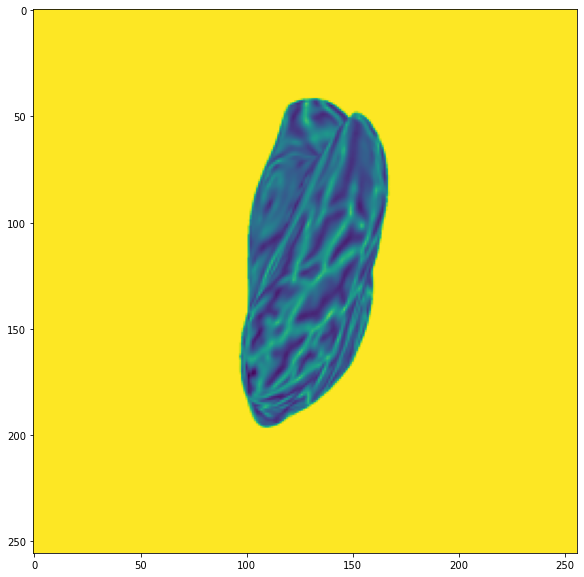

In [57]:
user.utils.imshow(xte[ind_to_viz])

In [62]:
testy_vis = y_vis_sample(yte[ind_to_viz])

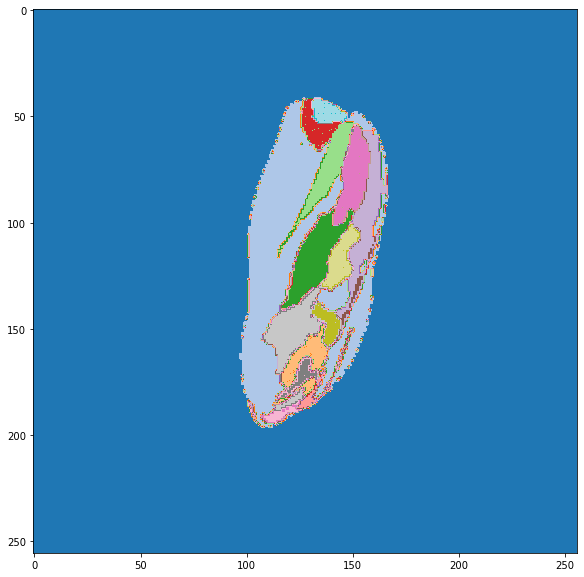

In [63]:
# note: option to specify cmap, e.g. tab20, appropriate for current # of classes
user.utils.imshow(testy_vis, cmap='tab20') # cmap='tab20'

## 2. Define Unet and train

In [89]:
reset_model_var = False
if reset_model_var:
    del model

In [68]:
out_channels_agg = yte.shape[1]
out_channels

21

In [91]:
model = va.UNet(feature_count=in_channels, class_count=out_channels_agg, apply_sigmoid=False)

In [69]:
device = user.utils.get_device()
device

device(type='cuda', index=0)

In [93]:
model.to(device)

UNet(
  (base_model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [94]:
summarize = False
if summarize:
    model_summary = summary(model, (1, 256, 256))

In [95]:
# training proceeds along this plan
# shifts weight from bcd to dice
epochs = 2
training_plan = [
    dict(lr=0.00375, gamma=0.9, num_epochs=epochs,  bce_weight=0.67),
    # dict(lr=0.00250, gamma=0.9, num_epochs=epochs,  bce_weight=0.33),
    # dict(lr=0.00125, gamma=0.9, num_epochs=epochs,  bce_weight=0.00)
]

training_plan_short = [dict(lr=0.00375, gamma=0.9, num_epochs=1,  bce_weight=0.67)]

In [96]:
xtr, ytr = next(iter(dl_train))
xte, yte = next(iter(dl_test))

In [97]:
xtr.shape, ytr.shape, xte.shape, yte.shape

(torch.Size([32, 1, 256, 256]),
 torch.Size([32, 21, 256, 256]),
 torch.Size([32, 1, 256, 256]),
 torch.Size([32, 21, 256, 256]))

In [71]:
dl_dict = {'trn': dl_train, 'val': dl_test}

In [99]:
model_save_dir = './model_checkpoints_parcellation-5-26.1'
os.makedirs(model_save_dir, exist_ok=True)

In [111]:
tp = training_plan_short  # abbreviated for testing
for e, t in enumerate(tp):
    # get hyperparameters
    lr = t['lr']
    gamma = t['gamma']
    num_epochs = t['num_epochs']
    bce_weight = t['bce_weight']
    
    # define training objects
    # Create the optimizer.
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    # Next, create the scheduler.
    step_size = len(dl_dict['trn']) 
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size=step_size,
        gamma=gamma)
    
    # train 
    model, labels, options = va.train.train_model(model, optimizer, scheduler, dl_dict, 
                                 save_path=model_save_dir, report_every=5,
                                 logits=True, num_epochs=num_epochs)

epoch    lr     dt[s]   trn bce   trn dice  trn loss   val bce   val dice  val loss
=====--=======--=====-+-========--========--========-+-========--========--========
Batches processed: 5; Training loss: 0.01958714798092842
Batches processed: 10; Training loss: 0.016720566898584366
Batches processed: 15; Training loss: 0.0157899372279644
Batches processed: 20; Training loss: 0.014609125442802906
Batches processed: 25; Training loss: 0.01508159376680851
Batches processed: 30; Training loss: 0.013417823240160942
Batches processed: 35; Training loss: 0.012743561528623104
Batches processed: 40; Training loss: 0.01246240921318531
Batches processed: 45; Training loss: 0.013084041886031628
Batches processed: 50; Training loss: 0.012978563085198402
Batches processed: 55; Training loss: 0.012356161139905453
Batches processed: 60; Training loss: 0.011786676943302155
Batches processed: 65; Training loss: 0.011044134385883808
Batches processed: 70; Training loss: 0.011355441994965076
Batches proc

Batches processed: 680; Training loss: 0.008215549401938915
Batches processed: 685; Training loss: 0.008488265797495842
Batches processed: 690; Training loss: 0.009279608726501465
Batches processed: 695; Training loss: 0.007719975896179676
Batches processed: 700; Training loss: 0.007556558586657047
Batches processed: 705; Training loss: 0.007750035263597965
Batches processed: 710; Training loss: 0.007257899269461632
Batches processed: 715; Training loss: 0.007927660830318928
Batches processed: 720; Training loss: 0.007526800036430359
Batches processed: 725; Training loss: 0.007339788600802422
Batches processed: 730; Training loss: 0.0079596396535635
Batches processed: 735; Training loss: 0.007244693115353584
Batches processed: 740; Training loss: 0.0072248890064656734
Batches processed: 745; Training loss: 0.007229069247841835
Batches processed: 750; Training loss: 0.007772714365273714
Batches processed: 755; Training loss: 0.008206088095903397
Batches processed: 760; Training loss: 0.

Batches processed: 1360; Training loss: 0.006613715551793575
Batches processed: 1365; Training loss: 0.007877083495259285
Batches processed: 1370; Training loss: 0.006752404384315014
Batches processed: 1375; Training loss: 0.006761630997061729
Batches processed: 1380; Training loss: 0.006997913587838411
Batches processed: 1385; Training loss: 0.0065000019967556
Batches processed: 1390; Training loss: 0.006352172698825598
Batches processed: 1395; Training loss: 0.0064161415211856365
Batches processed: 1400; Training loss: 0.0072492631152272224
Batches processed: 1405; Training loss: 0.006546409800648689
Batches processed: 1410; Training loss: 0.005914275534451008
Batches processed: 1415; Training loss: 0.006859895307570696
Batches processed: 1420; Training loss: 0.006569539662450552
Batches processed: 1425; Training loss: 0.007051555439829826
Batches processed: 1430; Training loss: 0.006760090589523315
Batches processed: 1435; Training loss: 0.006635216064751148
Batches processed: 1440;

Batches processed: 2035; Training loss: 0.008958226069808006
Batches processed: 2040; Training loss: 0.006207051686942577
Batches processed: 2045; Training loss: 0.006803290918469429
Batches processed: 2050; Training loss: 0.006427325773984194
Batches processed: 2055; Training loss: 0.006471182219684124
Batches processed: 2060; Training loss: 0.006982123479247093
Batches processed: 2065; Training loss: 0.006183582358062267
Batches processed: 2070; Training loss: 0.006019663065671921
Batches processed: 2075; Training loss: 0.007458200212568045
Batches processed: 2080; Training loss: 0.006352299824357033
Batches processed: 2085; Training loss: 0.007070901338011026
Batches processed: 2090; Training loss: 0.006357346661388874
Batches processed: 2095; Training loss: 0.005862235091626644
Batches processed: 2100; Training loss: 0.006501620635390282
Batches processed: 2105; Training loss: 0.006065367721021175
Batches processed: 2110; Training loss: 0.006247273646295071
Batches processed: 2115;

Batches processed: 240; Training loss: 0.007012504152953625
Batches processed: 245; Training loss: 0.00636264868080616
Batches processed: 250; Training loss: 0.0067015159875154495
Batches processed: 255; Training loss: 0.007371123880147934
Batches processed: 260; Training loss: 0.006460780277848244
Batches processed: 265; Training loss: 0.006118977442383766
Batches processed: 270; Training loss: 0.006297876127064228
Batches processed: 275; Training loss: 0.007074723020195961
 1/ 1  0.00375  26848.3 |    0.179     0.324     0.251 |    0.151     0.288     0.219 *
Best val loss: 0.219457


## 3. Investigate results

In [65]:
model_save_dir = './model_checkpoints_parcellation-5-26.1'
model_fp = f'{model_save_dir}/parc-2.pth'
torch.save(model, model_fp)

NameError: name 'model' is not defined

In [70]:
model = torch.load(model_fp)

device = user.utils.get_device()
model.to(device)

UNet(
  (base_model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [72]:
xv_cpu, yv_cpu = next(iter(dl_dict['val']))
xv = xv_cpu.to(device)
yv = yv_cpu.to(device)

In [73]:
model.eval()  # ensure model is in evaluation mode (turns off dropout, etc.)
pred = model(xv)
pred.shape

torch.Size([32, 21, 256, 256])

In [99]:
# visualize Difference between correct and incorrect labels

ind = 5

pred_cpu_sample = y_vis_sample(pred.cpu().detach()[ind])
yv_cpu_sample = y_vis_sample(yv.cpu().detach()[ind])

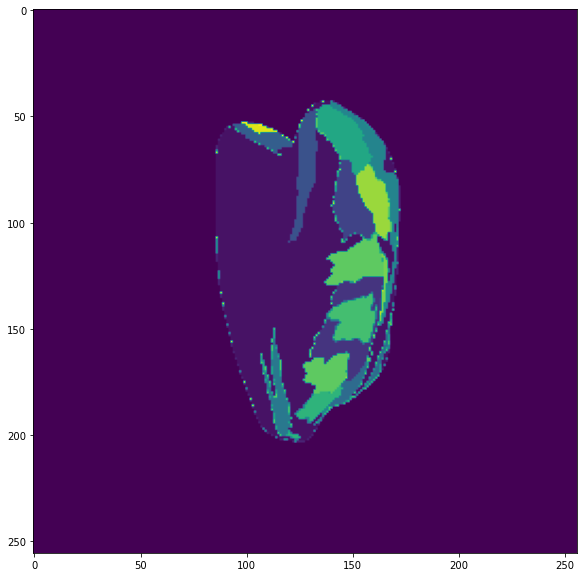

In [104]:
user.utils.imshow(yv_cpu_sample)
# user.utils.imshow(pred_cpu_sample)

In [76]:
pred.shape

torch.Size([32, 21, 256, 256])

In [85]:
pred_am = pred.argmax(dim=1).cpu()
yv_am = yv.argmax(dim=1).cpu()

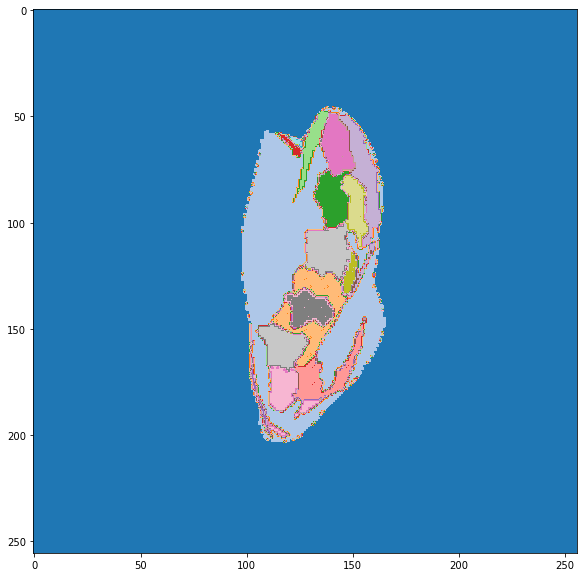

In [93]:
ind = 0

fig, ax = plt.subplots(figsize=(10, 10))
#plt.imshow(pred_am[ind], cmap='tab20')
plt.imshow(yv_am[ind], cmap='tab20')

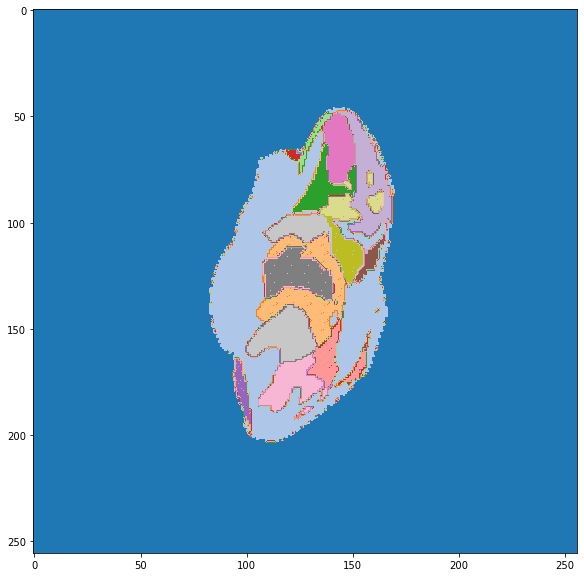

In [120]:
user.utils.imshow(pvc, cmap='tab20')

In [121]:
pred_cpu_sample.shape

torch.Size([1, 256, 256])

In [ ]:
### SOME IMPLEMENTATION ERROR!

### -- WHY does the test dataset have batchsize 10 != 32 ??
### -- Make sure SIGMOID OUTPUT is being handled correctly and consistently across references
### -- Make sure LOSS is being handled correctly, consistently

In [94]:
### -- Think a lot about masking
### -- make sure yooure using train correctly
### -- e.g., ensure model isn't being secretly RESET or ERASED

In [6]:
arr = np.array([1,2,3])

In [7]:
arr

array([1, 2, 3])

In [18]:
last_trn_loss = 1.3
last_val_loss = 1.0
last_val_bce = 0.75643
last_val_dice = 0.4434385


print(f'Train loss: {last_trn_loss:.5f}; '
      f'Val loss: {last_val_loss:.5f}; '
      f'Val bce: {last_val_bce:.5f}; '
      f'Val dice: {last_val_dice:.5f}')

Train loss: 1.30000; Val loss: 1.00000; Val bce: 0.75643; Val dice: 0.44344
